In [4]:
import pandas as pd
import numpy as np


In [33]:
n400 = pd.read_csv("N400_by_trial.csv")
#in case we trian only on the 3 electrodes
n400c = n400[['ItemNum', 'Condition', 'T8', 'PO9', 'P7']]
n400sr = n400[['ItemNum', 'Condition','O1', 'Oz', 'Pz']]
n400sur = n400[['ItemNum', 'Condition','PO9', 'T7', 'O1']]

p600 = pd.read_csv("P600_by_trial.csv")
#in case we trian only on the 3 electrodes
p600c = p600[['ItemNum', 'Condition','T8', 'PO9', 'P7']]
p600sr = p600[['ItemNum', 'Condition','O1', 'Oz', 'Pz']]
p600sur = p600[['ItemNum', 'Condition','PO9', 'T7', 'O1']]
spr = pd.read_csv("SPR_by_trial.csv")

Index(['ItemNum', 'Condition', 'Timestamp', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz',
       'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8',
       'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8',
       'PO9', 'O1', 'Oz', 'O2', 'PO10'],
      dtype='object')
Index(['ItemNum', 'Condition', 'Timestamp', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz',
       'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8',
       'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8',
       'PO9', 'O1', 'Oz', 'O2', 'PO10'],
      dtype='object')
Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10


In [388]:
def extract_features(dataframe: pd.DataFrame, condition):
    """
    Extracts features from a dataframe of ERPs / SRP's. 
    
    Args:
        dataframe: A dataframe of ERPs / SRP's.
        condition: The condition to extract features from.
    Returns:
        A numpy array of features.
    """
    
    features = dataframe[dataframe["Condition"] == condition]
    features = features.drop(["Condition"], axis=1)
    features = features.set_index("ItemNum")
    features = np.expand_dims(features.to_numpy(), axis=0)
    return features

n400_control = extract_features(n400, "control")
n400_script_related = extract_features(n400, "script-related")
n400_script_unrelated = extract_features(n400, "script-unrelated")

p600_control = extract_features(p600, "control")
p600_script_related = extract_features(p600, "script-related")
p600_script_unrelated = extract_features(p600, "script-unrelated")

spr_control = extract_features(spr, "control")
spr_script_related = extract_features(spr, "script-related")
spr_script_unrelated = extract_features(spr, "script-unrelated")

### Visualise data

In [35]:
def print_item(item = 0):
    print(f"ItemNum: {item+1}")
    print(f"ERP's (n400): \n{n400_control[0][item]}")
    print(f"SPR: {spr_control[0][item]}")

print_item(0)

ItemNum: 1
ERP's (n400): 
[ 0.23308025  1.68755694 -0.30686479]
SPR: [432.36363636]


In [389]:
# check data shape
print(spr_control.shape)
print(n400_control.shape)
print(p600_control.shape)

# check data type
print(type(spr_control))
print(n400_control.dtype)
print(p600_control.dtype)

(1, 90, 1)
(1, 90, 33)
(1, 90, 33)
<class 'numpy.ndarray'>
float64
float64


### Prepare data for training

In [37]:
from sklearn.model_selection import train_test_split

In [390]:
X = np.concatenate((n400_script_related, p600_script_related), axis=0)
y = np.reshape(spr_script_related, (90, 1, 1))

# reshape x to have 90 in first dimension
X = np.reshape(X, (90, X.shape[0], 33))


array([[[585.7       ]],

       [[287.5       ]],

       [[565.27272727]],

       [[625.1       ]],

       [[285.7       ]],

       [[658.        ]],

       [[403.1       ]],

       [[366.7       ]],

       [[566.36363636]],

       [[562.1       ]],

       [[355.7       ]],

       [[413.90909091]],

       [[426.2       ]],

       [[320.        ]],

       [[393.36363636]],

       [[427.9       ]],

       [[412.9       ]],

       [[406.45454545]],

       [[565.7       ]],

       [[320.3       ]],

       [[376.18181818]],

       [[467.7       ]],

       [[284.6       ]],

       [[424.        ]],

       [[495.        ]],

       [[330.        ]],

       [[546.1       ]],

       [[584.7       ]],

       [[266.3       ]],

       [[456.27272727]],

       [[433.6       ]],

       [[261.8       ]],

       [[472.54545455]],

       [[474.2       ]],

       [[324.8       ]],

       [[385.63636364]],

       [[674.4       ]],

       [[319.1       ]],

       [[584

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [392]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (72, 2, 33)
y_train shape: (72, 1, 1)


### Helpers

In [393]:
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

get_custom_objects().update({"r_squared": r_squared})

In [394]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_r_squared', patience=20)

### Construct RNN Model

In [395]:
# from tensorflow import Sequential
import keras
from keras import layers, Sequential
keras.utils.set_random_seed(42)

In [413]:
# make an rnn model that takes in the n400 and p600 data and predicts the spr data

model = Sequential()
model.add(layers.Input(shape=(2, 33)))
model.add(layers.LSTM(32, input_shape=(2, 33)))
#model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(128, activation="relu"))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.25))
#model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="relu"))

model.compile(optimizer="adam", loss="mae", metrics=['mae', 'mse', 'r_squared'])

model.summary()

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 32)                8448      
                                                                 
 dropout_446 (Dropout)       (None, 32)                0         
                                                                 
 dense_541 (Dense)           (None, 128)               4224      
                                                                 
 dropout_447 (Dropout)       (None, 128)               0         
                                                                 
 dense_542 (Dense)           (None, 256)               33024     
                                                                 
 dropout_448 (Dropout)       (None, 256)               0         
                                                                 
 dropout_449 (Dropout)       (None, 256)            

In [438]:
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.3)

Epoch 1/200
1/1 [==============================] - 0s 145ms/step - loss: 98.0263 - mae: 98.0263 - mse: 19154.5059 - r_squared: -0.3448 - val_loss: 66.8416 - val_mae: 66.8416 - val_mse: 6763.8315 - val_r_squared: -0.0504
Epoch 2/200
1/1 [==============================] - 0s 95ms/step - loss: 106.8308 - mae: 106.8308 - mse: 21070.3027 - r_squared: -0.4793 - val_loss: 66.8093 - val_mae: 66.8093 - val_mse: 6760.6060 - val_r_squared: -0.0499
Epoch 3/200
1/1 [==============================] - 0s 85ms/step - loss: 109.3943 - mae: 109.3943 - mse: 20821.9355 - r_squared: -0.4619 - val_loss: 66.6873 - val_mae: 66.6873 - val_mse: 6730.3042 - val_r_squared: -0.0452
Epoch 4/200
1/1 [==============================] - 0s 81ms/step - loss: 107.5833 - mae: 107.5833 - mse: 20794.0820 - r_squared: -0.4599 - val_loss: 66.4468 - val_mae: 66.4468 - val_mse: 6674.3716 - val_r_squared: -0.0365
Epoch 5/200
1/1 [==============================] - 0s 74ms/step - loss: 121.1598 - mae: 121.1598 - mse: 25106.9355 - 

### Test model

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

In [439]:
pred = model.predict(X_test)

# remove 1 dim from y_test to match pred
y_test_ = np.squeeze(y_test, axis=1)
pred = np.squeeze(pred, axis=1)

mse = mean_squared_error(y_test_, pred)
print(f"\nMSE: {mse}")

r_squared = r2_score(y_test_, pred)
print(f"R^2: {r_squared}")

print("\nFirst 5 predictions: ")
for i in range(min(len(pred), 5)):
    print(f"pred: {round(pred[i])}", end=" ")
    print(f"actual: {round(y_test_[i][0])}")

1/1 [==============================] - 0s 47ms/step

MSE: 7758.983234890895
R^2: 0.11877689873419894

First 5 predictions: 
pred: 408 actual: 382
pred: 374 actual: 285
pred: 395 actual: 352
pred: 392 actual: 398
pred: 402 actual: 586


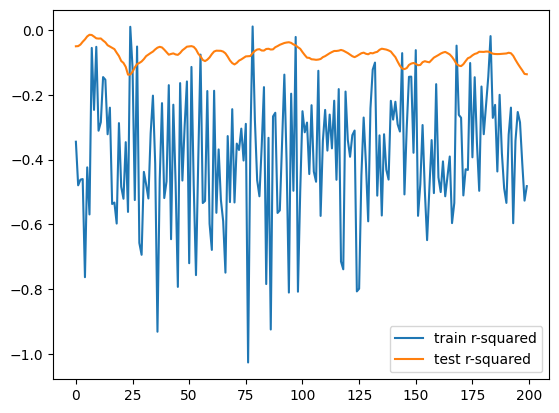

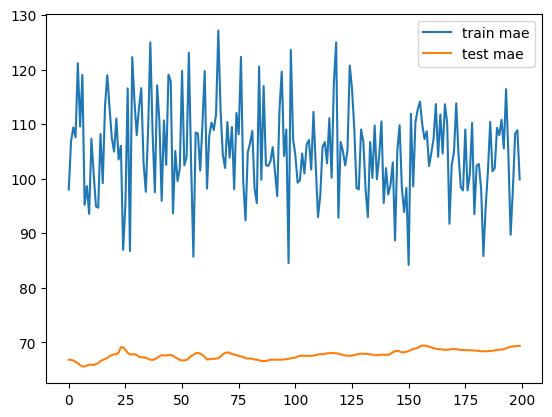

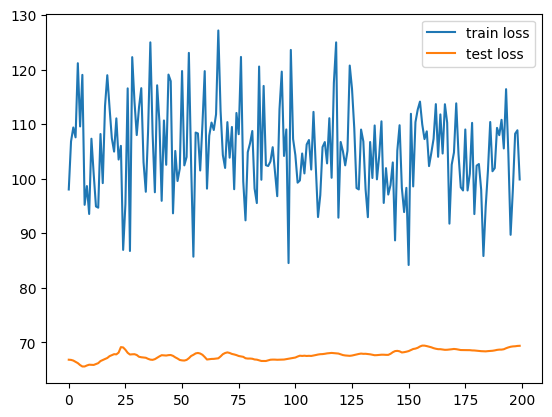

In [440]:
# plot history
import matplotlib.pyplot as plt

plt.plot(history.history['r_squared'], label='train r-squared')
plt.plot(history.history['val_r_squared'], label='test r-squared')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='test mae')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
